In [ ]:
import yfinance as yf
from datetime import datetime
from datetime import date
import numpy as np
import matplotlib.pyplot as plt

# Define the date range
start_date = date(2024, 4, 5)
end_date = date(2025, 10, 6)

# Calculate the number of business days between the dates
total_days = np.busday_count(start_date, end_date)

# Convert days to years
T = total_days / 252

# Contract features
CAP = 3422.5882
BONUS = 3198.40
B = 2391.33
m = 0.33454

# Value of the underlying at the issuance date
S0 = 2989.16

[*********************100%***********************]  1 of 1 completed


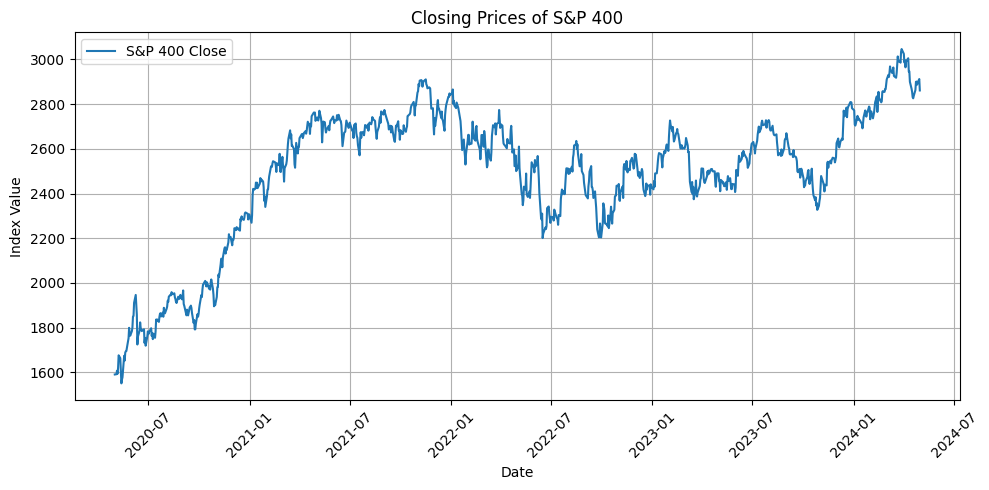

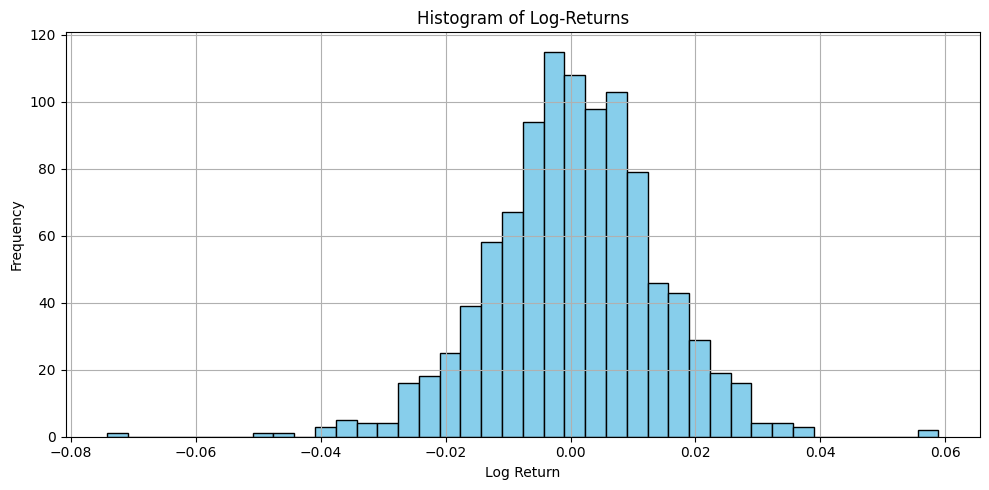

In [ ]:
# Historical performance of the underlying: S&P 400 MidCap

# choose the dates
myStart = datetime(2020,5,1)
myEnd = datetime(2024,5,1)
data = yf.download("^MID", start = myStart, end = myEnd)

dates = data.index
prices = data["Close"].to_numpy()


plt.figure(figsize=(10, 5))
plt.plot(dates, prices, label="S&P 400 Close")
#plt.plot([dates[0], dates[-1]], [B,B], color='red', linestyle='--', label='barrier level')
plt.title("Closing Prices of S&P 400")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Calcolo dei daily log-returns
log_returns = np.log(prices[1:] / prices[:-1])
log_returns = log_returns.flatten()

# Istogramma di frequenza dei log-returns
plt.figure(figsize=(10, 5))
plt.hist(log_returns, bins=40, color='skyblue', edgecolor='black')
plt.title("Histogram of Log-Returns")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


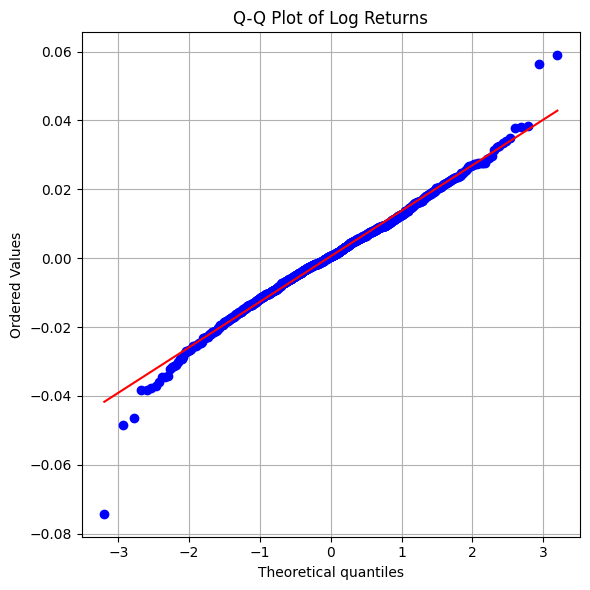

Shapiro-Wilk Test:
  Statistic = 0.9878, p-value = 0.0000
Jarque-Bera Test:
  Statistic = 122.6929, p-value = 0.0000


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import shapiro, jarque_bera, probplot

# Q-Q plot
plt.figure(figsize=(6, 6))
probplot(log_returns, dist="norm", plot=plt)
plt.title("Q-Q Plot of Log Returns")
plt.grid(True)
plt.tight_layout()
plt.show()

# Shapiro-Wilk Test
shapiro_stat, shapiro_p = shapiro(log_returns)
print(f"Shapiro-Wilk Test:\n  Statistic = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")

# Jarque-Bera Test
jb_stat, jb_p = jarque_bera(log_returns)
print(f"Jarque-Bera Test:\n  Statistic = {jb_stat:.4f}, p-value = {jb_p:.4f}")

In [ ]:
vix_data = yf.download("^VIX", start="2024-04-04", end="2024-04-06", interval="60m")
vix = vix_data['Close'].iloc[-1]
print(vix)

[*********************100%***********************]  1 of 1 completed

Ticker
^VIX    16.049999
Name: 2024-04-05 20:00:00+00:00, dtype: float64


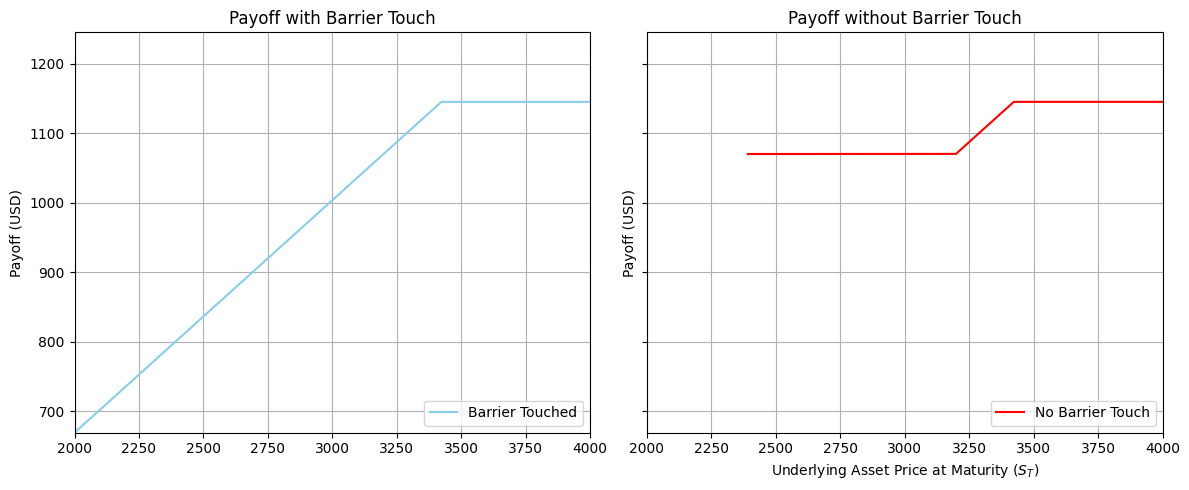

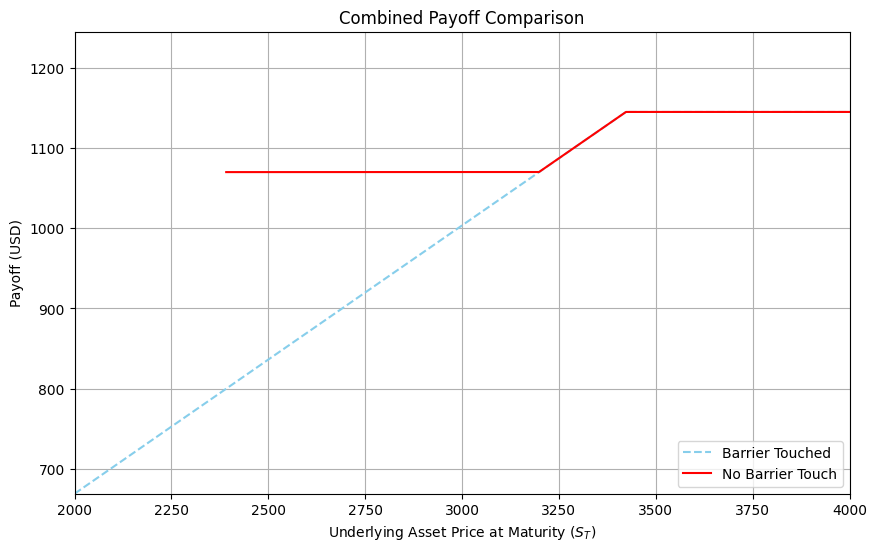

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Asset price range
ST = np.linspace(2000, 4000, 20000)

# Payoff: barrier touched
payoff_barrier = m * CAP - m * np.maximum(CAP - ST, 0)

# Payoff: no barrier touched (only for ST > B)
ST_no_barrier = ST[ST > B]
payoff_no_barrier = (
    m * CAP - m * np.maximum(CAP - ST_no_barrier, 0) +
    m * np.maximum(BONUS - ST_no_barrier, 0)
)

# Common axis limits
x_min = ST[0]
x_max = ST[-1]
y_min = min(payoff_barrier.min(), payoff_no_barrier.min())
y_max = max(payoff_barrier.max(), payoff_no_barrier.max()) + 100

# --- Create 1x2 grid plot (smaller) ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot 1: Barrier touched
axs[0].plot(ST, payoff_barrier, color='skyblue', label='Barrier Touched')
axs[0].set_title('Payoff with Barrier Touch')
axs[0].set_ylabel('Payoff (USD)')
axs[0].set_xlim(x_min, x_max)
axs[0].set_ylim(y_min, y_max)
axs[0].grid(True)
axs[0].legend(loc='lower right')

# Plot 2: No barrier touched
axs[1].plot(ST_no_barrier, payoff_no_barrier, color='red', label='No Barrier Touch')
axs[1].set_title('Payoff without Barrier Touch')
axs[1].set_xlabel('Underlying Asset Price at Maturity ($S_T$)')
axs[1].set_ylabel('Payoff (USD)')
axs[1].set_xlim(x_min, x_max)
axs[1].set_ylim(y_min, y_max)
axs[1].grid(True)
axs[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

# --- Combined plot (larger) ---
plt.figure(figsize=(10, 6))
plt.plot(ST, payoff_barrier, color='skyblue', linestyle='dashed', label='Barrier Touched')
plt.plot(ST_no_barrier, payoff_no_barrier, color='red', label='No Barrier Touch')
plt.title('Combined Payoff Comparison')
plt.xlabel('Underlying Asset Price at Maturity ($S_T$)')
plt.ylabel('Payoff (USD)')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()


In [ ]:
# ------------------- Pricing in a BS framework ---------------------------

# -------------------------------------------------------------------------------
# After an unsuccessful attempt to calibrate a Heston model for volatility,
# we decided to price the certificate within the Black-Scholes framework,
# acknowledging its limitations and approximations.
# -------------------------------------------------------------------------------

# The first and most significant simplification is the assumption of
# constant implied volatility.
# In this context, we use the VIX index on the issue date as a proxy.
# Although the VIX reflects implied volatility on S&P 500 options, and not the S&P 400,
# we assume it still captures general market expectations under the risk-neutral
# measure Q.
# This is an approximation, but it's the best available proxy in the absence
# of a volatility index specific to the S&P 400.

# The second assumption concerns the risk-free rate, also treated as constant over time.
# As a proxy for 'r', we use the 1-year U.S. Treasury Bill yield, sourced from FRED.
# This is justified by the USD denomination of the certificate and its approximate
# 1.5-year maturity.

# Lastly, the dividend yield 'q' was estimated using an ETF that tracks the S&P 400,
# due to the lack of reliable direct data on the index itself.
# This further illustrates the data limitations that led us to adopt a simpler
# pricing framework.

# -------------------------------------------------------------------------------
# Why Black-Scholes over Heston?
# The absence of options directly written on the S&P 400 and the scarcity of derivatives
# on related ETFs made Heston calibration unfeasible.
# The few available options (typically ATM and short-dated) showed
# low volume and open interest, suggesting a pricing method that does not reflect the
# behavior of a representative market.
# Once again, this supports the view that the S&P 400 is often overlooked by investors.
# -------------------------------------------------------------------------------

from scipy.stats import norm

r = 4.82/100          # assume a risk-free rate of 4.82% (from FRED website, date = 5th April 2024)
sigma = 16.05/100     # assume a constant volatility of underlying of 16.05% (VIX index, close price, 5th April 2024)
q = 1.64/100          # assume a dividend yield of underlying of 1.64% (from SPDR S&P 400 U.S. Mid Cap UCITS ETF)

def PriceBS(S0, sigma, r, T):

  # ---------------- The replicating portofolio is composed of: ---------------------------

  # 1. ZCB with face value of m*CAP (quantity = + 1)
  FV = m * CAP
  bond = FV*np.exp(-r*T)

  # 2. put option with strike = CAP (quantity = - m)
  K1 = CAP
  d1 = (np.log(S0/K1) + (r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
  d2 = d1 - sigma*np.sqrt(T)
  put = K1 * np.exp(-r*T) * norm.cdf(-d2) - S0 * np.exp(-q*T) * norm.cdf(-d1)

  # 3. down and out barrier put option with strike = BONUS and barrier level = B (quantity = + m)
  # (the pricing formula is taken from Hull, 11th edition, "Option, Futures and Other Derivatives")
  K2 = BONUS
  H = B
  D1 = (np.log(S0/K2) + (r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
  D2 = D1 - sigma*np.sqrt(T)
  put_vanilla = K2 * np.exp(-r*T) * norm.cdf(-D2) - S0 * np.exp(-q*T) * norm.cdf(-D1)

  l = (r - q + 0.5*sigma**2)/(sigma**2)
  y = (np.log(H**2/(S0*K2)))/(sigma*np.sqrt(T)) + l*sigma*np.sqrt(T)
  x1 = (np.log(S0/H))/(sigma*np.sqrt(T)) + l*sigma*np.sqrt(T)
  y1 = (np.log(H/S0))/(sigma*np.sqrt(T)) + l*sigma*np.sqrt(T)

  DI_put = - S0 * np.exp(-q*T) * norm.cdf(-x1) + K2 * np.exp(-r*T) * norm.cdf(-x1 + sigma*np.sqrt(T)) + \
        S0 * np.exp(-q*T) * (H/S0)**(2*l) * (norm.cdf(y) - norm.cdf(y1)) - \
        K2 * np.exp(-r*T) * (H/S0)**(2*l - 2) * (norm.cdf(y - sigma*np.sqrt(T)) - norm.cdf(y1 - sigma*np.sqrt(T)))

  DO_put = put_vanilla - DI_put

  # so the final price of the certificate is:
  price = bond - m * put + m * DO_put * (S0 > H)

  return price

In [ ]:
print(f"The price of the Certificate is: {PriceBS(S0,sigma,r,T):.2f} USD")

The price of the Certificate is: 965.25 USD


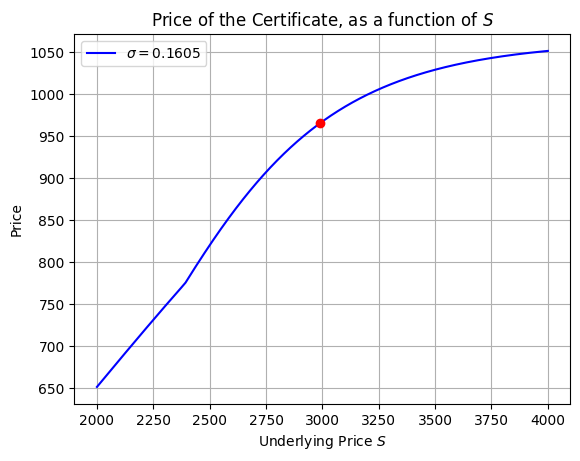

In [ ]:
prices = np.array([PriceBS(S, sigma, r, T) for S in ST])

# Plot
plt.plot(ST, prices, label=f"$\\sigma = {sigma}$", color="blue")
plt.plot(S0, PriceBS(S0,sigma,r,T), 'ro')
plt.title("Price of the Certificate, as a function of $S$")
plt.xlabel("Underlying Price $S$")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Greeks

# Valori di input
S0 = 2989.16
h = 0.01
eps = 1e-4

# Delta
price_up = PriceBS(S0 + h, sigma, r, T)
price_down = PriceBS(S0 - h, sigma, r, T)
price = PriceBS(S0, sigma, r, T)
deltaC = (price_up - price_down) / (2 * h)

# Gamma
gamma_valC = (price_up - 2 * price + price_down) / h**2

# Vega
price_sigma_up = PriceBS(S0, sigma + eps, r, T)
price_sigma_down = PriceBS(S0, sigma - eps, r, T)
vega_valC = (price_sigma_up - price_sigma_down) / (2 * eps)

# Volga
volga_valC = (price_sigma_up - 2 * price + price_sigma_down) / eps**2

# Rho
price_r_up = PriceBS(S0, sigma, r + eps, T)
price_r_down = PriceBS(S0, sigma, r - eps, T)
rho_valC = (price_r_up - price_r_down) / (2 * eps)

# Theta (numerical derivative w.r.t. time passing)
price_T_down = PriceBS(S0, sigma, r, T - h)
theta_valC = - (price - price_T_down) / h

# Vanna
price_up_up = PriceBS(S0 + h, sigma + eps, r, T)
price_up_down = PriceBS(S0 + h, sigma - eps, r, T)
price_down_up = PriceBS(S0 - h, sigma + eps, r, T)
price_down_down = PriceBS(S0 - h, sigma - eps, r, T)
vanna_valC = (price_up_up - price_up_down - price_down_up + price_down_down) / (4 * h * eps)

# Print the Greeks at S0
print(f"\nGreeks at S = S0 = {S0}:")
print(f"Delta  = {deltaC:.6f}")
print(f"Gamma  = {gamma_valC:.6f}")
print(f"Vega   = {vega_valC:.6f}")
print(f"Volga  = {volga_valC:.6f}")
print(f"Rho    = {rho_valC:.6f}")
print(f"Theta  = {theta_valC:.6f}")
print(f"Vanna  = {vanna_valC:.6f}")



Greeks at S = S0 = 2989.16:
Delta  = 0.195977
Gamma  = -0.000359
Vega   = -756.624002
Volga  = 480.738413
Rho    = -696.695618
Theta  = 69.342434
Vanna  = 0.382669


In [ ]:


h = 0.01
eps = 1e-4
deltas = []
gammas = []
vegas = []
rhos = []
thetas = []
volgas = []
vannas = []


for S in ST:

    price_up = PriceBS(S + h, sigma, r, T)
    price_down = PriceBS(S - h, sigma, r, T)
    price = PriceBS(S, sigma, r, T)
    delta = (price_up - price_down) / (2 * h)
    deltas.append(delta)

    gamma_val = (price_up - 2 * price + price_down) / h**2
    gammas.append(gamma_val)

    price_sigma_up = PriceBS(S, sigma + eps, r, T)
    price_sigma_down = PriceBS(S, sigma - eps, r, T)
    vega_val = (price_sigma_up - price_sigma_down) / (2 * eps)
    vegas.append(vega_val)

    volga_val = (price_sigma_up - 2 * price + price_sigma_down) / eps**2
    volgas.append(volga_val)

    price_r_up = PriceBS(S, sigma, r + eps, T)
    price_r_down = PriceBS(S, sigma, r - eps, T)
    rho_val = (price_r_up - price_r_down) / (2 * eps)
    rhos.append(rho_val)

    price_T_down = PriceBS(S, sigma, r, T - h)
    theta_val = - (price - price_T_down) / (h)
    thetas.append(theta_val)

    price_up_up = PriceBS(S + h, sigma + eps, r, T)
    price_up_down = PriceBS(S + h, sigma - eps, r, T)
    price_down_up = PriceBS(S - h, sigma + eps, r, T)
    price_down_down = PriceBS(S - h, sigma - eps, r, T)
    vanna_val = (price_up_up - price_up_down - price_down_up + price_down_down) / (4 * h * eps)
    vannas.append(vanna_val)



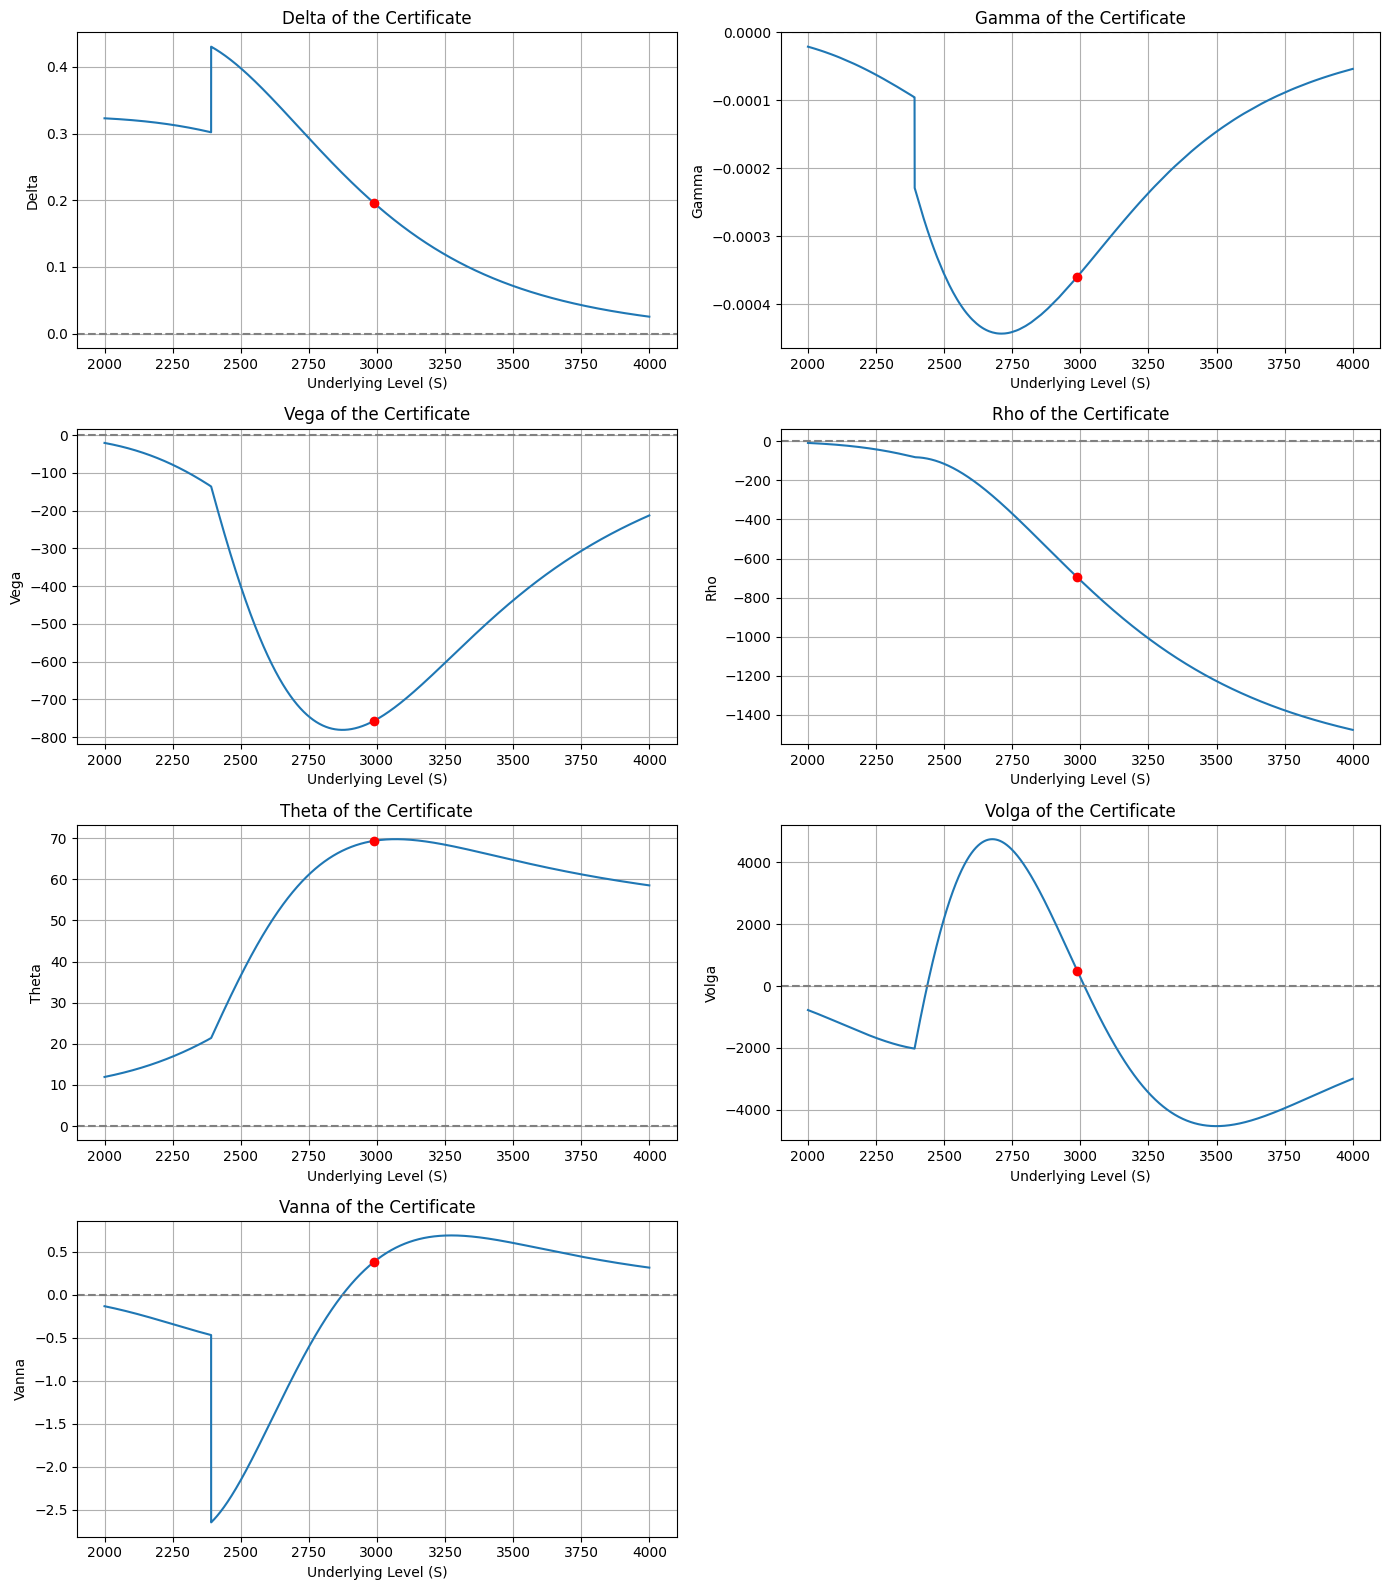

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()

greeks = [
    ("Delta", deltas, deltaC),
    ("Gamma", gammas, gamma_valC),
    ("Vega", vegas, vega_valC),
    ("Rho", rhos, rho_valC),
    ("Theta", thetas, theta_valC),
    ("Volga", volgas, volga_valC),
    ("Vanna", vannas, vanna_valC)
]

for i, (name, values, value_at_S0) in enumerate(greeks):
    axes[i].plot(ST, values, label=name)
    axes[i].plot(S0, value_at_S0, 'ro')
    axes[i].set_title(f"{name} of the Certificate")
    axes[i].set_xlabel("Underlying Level (S)")
    axes[i].set_ylabel(name)
    axes[i].grid(True)
    axes[i].axhline(0, color="gray", linestyle="--")

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

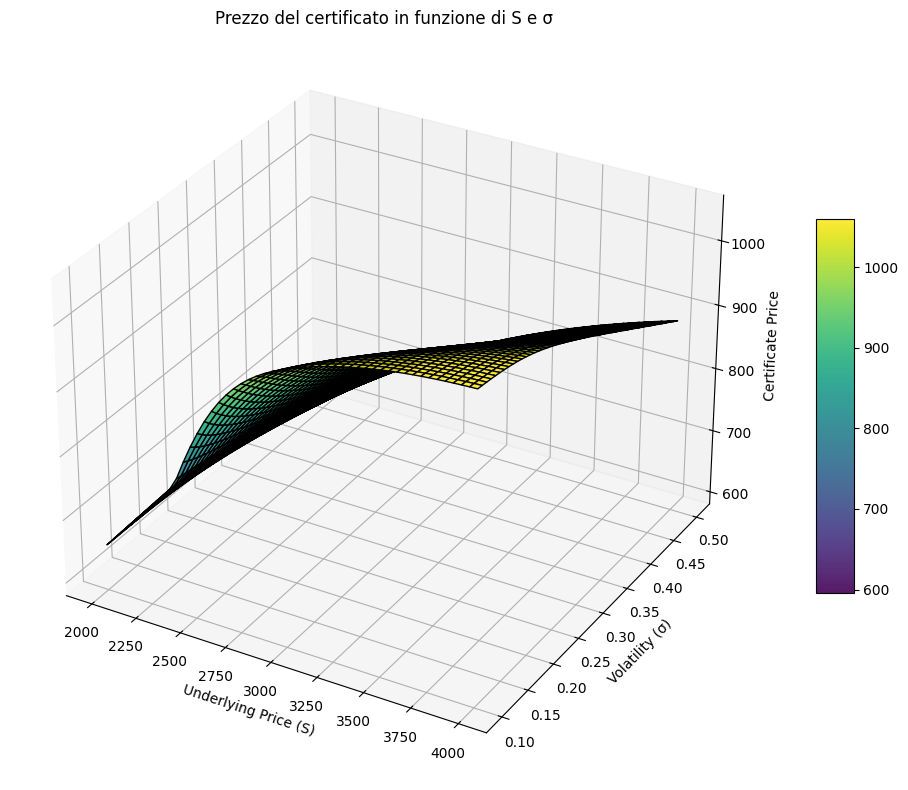

In [ ]:
import plotly.graph_objects as go
S_vals = np.linspace(2000, 4000, 50)
sigma_vals = np.linspace(0.1, 0.5, 50)
S_grid, sigma_grid = np.meshgrid(S_vals, sigma_vals)

price_grid = np.array([[PriceBS(S, sig, r, T) for S in S_vals] for sig in sigma_vals])

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(S_grid, sigma_grid, price_grid, cmap='viridis', edgecolor='k', alpha=0.9)

ax.set_title('Prezzo del certificato in funzione di S e σ')
ax.set_xlabel('Underlying Price (S)')
ax.set_ylabel('Volatility (σ)')
ax.set_zlabel('Certificate Price')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()

fig = go.Figure(data=[go.Surface(z=price_grid, x=S_vals, y=sigma_vals, colorscale='Viridis')])
fig.update_layout(
    title='Prezzo del certificato in funzione di S e σ',
    scene=dict(
        xaxis_title='Underlying Price (S)',
        yaxis_title='Volatility (σ)',
        zaxis_title='Certificate Price'
    ),
    autosize=True,
    margin=dict(l=40, r=40, b=40, t=40)
)

fig.show()